In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import torch
import xarray as xr
import matplotlib.pyplot as plt
import pyBigWig

import seqdata as sd

from eugene import preprocess as pp

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [6]:
# Paths
data_dir = "/cellar/users/aklie/data/datasets/ENCODE_examples/processed/2023_12_30/ATAC-seq/GM21381"
fasta = "/cellar/users/aklie/data/ref/genomes/hg38/hg38.fa"

In [7]:
# TODO: change to your paths
peaks = os.path.join(data_dir, "ENCFF766BZE.bed")
signal = os.path.join(data_dir, "counts_unstranded.bw")
peaks, signal

('/cellar/users/aklie/data/datasets/ENCODE_examples/processed/2023_12_30/ATAC-seq/GM21381/ENCFF766BZE.bed',
 '/cellar/users/aklie/data/datasets/ENCODE_examples/processed/2023_12_30/ATAC-seq/GM21381/counts_unstranded.bw')

In [10]:
# Make output directory if doesn't exist
out = os.path.join(data_dir, "GM21381.zarr")
out

'/cellar/users/aklie/data/datasets/ENCODE_examples/processed/2023_12_30/ATAC-seq/GM21381/GM21381.zarr'

In [9]:
sdata = sd.from_region_files(
    sd.GenomeFASTA('seq',
        fasta,
        batch_size=10000,
        n_threads=4,
    ),
    sd.BigWig(
        'cov',
        [signal],
        ["GM21381"],
        batch_size=10000,
        n_jobs=4,
        threads_per_job=2,
    ),
    path=out,
    fixed_length=2048,
    bed=peaks,
    overwrite=True,
    max_jitter=0
)
sdata.load()

100%|██████████| 95590/95590 [00:30<00:00, 3137.62it/s]
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
100%|██████████| 95590/95590 [00:58<00:00, 1646.37it/s]


<xarray.Dataset>
Dimensions:     (_sequence: 95590, cov_sample: 1, _length: 2048)
Coordinates:
  * cov_sample  (cov_sample) object 'GM21381'
Dimensions without coordinates: _sequence, _length
Data variables:
    blockCount  (_sequence) uint64 382 418 363 221 471 ... 79 1293 735 1158 78
    chrom       (_sequence) object 'chr5' 'chr4' 'chr4' ... 'chr10' 'chr5'
    chromEnd    (_sequence) int64 146204617 140525208 ... 102422376 112161905
    chromStart  (_sequence) int64 146202569 140523160 ... 102420328 112159857
    cov         (_sequence, cov_sample, _length) float32 0.0 0.0 0.0 ... 0.0 0.0
    itemRgb     (_sequence) object '987.86462' '983.01263' ... '0.43477'
    name        (_sequence) object '.' '.' '.' '.' '.' ... '.' '.' '.' '.' '.'
    score       (_sequence) float64 1e+03 1e+03 1e+03 ... 565.0 1e+03 1e+03
    seq         (_sequence, _length) |S1 b'T' b'T' b'T' b'T' ... b'G' b'G' b'T'
    strand      (_sequence) object '.' '.' '.' '.' '.' ... '.' '.' '.' '.' '.'
    thickEnd    (_sequence) int64 993 988 987 973 925 870 870 ... 2 2 2 2 2 2 2
    thickStart  (_sequence) int64 24 25 18 24 24 16 24 17 25 ... 1 1 1 1 1 1 1 1
Attributes:
    length_dim:    _length
    max_jitter:    0
    sequence_dim:  _sequence

In [8]:
# The actual BigWig file
file = pyBigWig.open(str(signal))

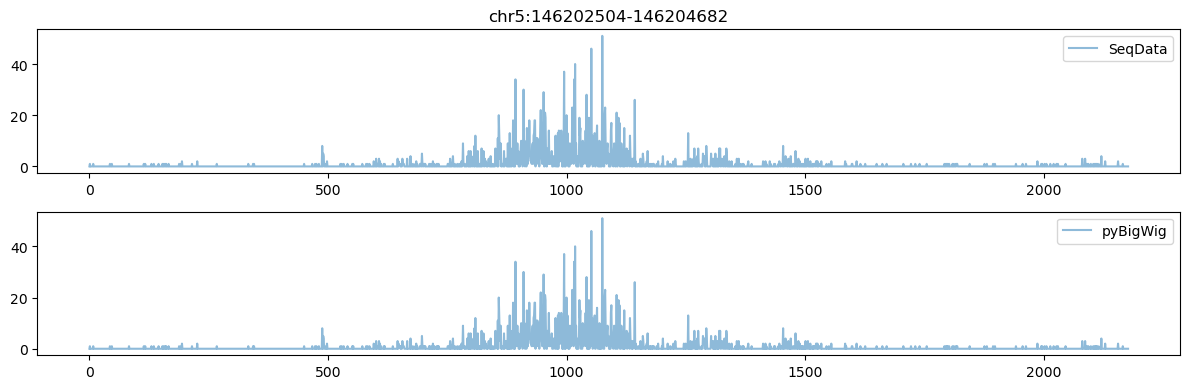

In [19]:
# Plot signal and control
seq_num = 0
ser = sdata[["name", "chrom", "chromStart", "chromEnd"]].to_dataframe().loc[seq_num]
fig, ax = plt.subplots(2, 1, figsize=(12,4))
ax[0].plot(sdata["cov"][seq_num].values.squeeze(), label="SeqData", alpha=0.5)
ax[0].legend()
vals = np.array(file.values(ser["chrom"], ser["chromStart"], ser["chromEnd"]))
vals = np.nan_to_num(vals)
ax[1].plot(vals, label="pyBigWig", alpha=0.5)
ax[0].set_title(ser["chrom"] + ":" + ser["chromStart"].astype(str) + "-" + ser["chromEnd"].astype(str))
ax[1].legend()
plt.tight_layout()